## Problem Formulation

I decided to focus on the State Drug Utilization Data because it provides structured, state-level Medicaid reimbursement information that allows me to analyze real pharmaceutical market behavior. My core research question is whether states systematically pay different reimbursement prices for the same drug and whether those differences persist over time. This is a measurable question because the dataset contains total reimbursement amounts and prescription counts at the state and quarterly level. I define my primary outcome variable as price per prescription, calculated as total reimbursement divided by number of prescriptions. The inputs for this analysis include state, year, quarter, National Drug Code (NDC), and reimbursement amounts. The time horizon initially focuses on 2025 data, but the dataset is available for previous years, allowing expansion into a multi-year panel analysis. This project is grounded in economic reasoning related to bargaining power, pricing dispersion, and market structure within regulated healthcare markets. I am not attempting to estimate manufacturer profit or production cost because those variables are not observable in this dataset. Instead, I focus on observable reimbursement outcomes and measurable price variation across states.

## Data Acquisition

The dataset used in this project is the State Drug Utilization Data published by the Centers for Medicare & Medicaid Services and accessed through Data.gov. The dataset is publicly available and licensed under public domain, making it fully reproducible. I downloaded the 2025 CSV file directly from the official CMS resource page. The dataset includes state-level quarterly records for covered outpatient drugs reimbursed under Medicaid. Key variables include National Drug Code, state abbreviation, prescription counts, units reimbursed, and total reimbursement amounts. Because the dataset is structured and standardized, it does not require web scraping or manual data collection. I stored the raw CSV file inside the project’s data folder to ensure reproducibility. All preprocessing steps are documented within the database notebook to ensure transparency and consistency.

Source: https://healthdata.gov/CMS/State-Drug-Utilization-Data-2024/atef-9yh4/about_data


## Data Acquisition II (Database Implementation)

To move from flat file analysis to structured querying, I created a SQLite database named medicaid_drugs.db. The database consists of two relational tables: a drug reference table and a utilization fact table. The drug table stores one row per unique NDC and includes static drug attributes such as labeler code, product code, package size, and product name. The utilization table stores state-level quarterly reimbursement records and includes prescription counts, reimbursement totals, and time variables. A one-to-many relationship exists between the drug and utilization tables, enforced by a foreign key linking utilization.ndc to drug.ndc. I inserted unique NDC entries into the drug table first to preserve referential integrity. I then inserted all state-level quarterly records into the utilization table. This schema separates static drug metadata from time-varying reimbursement outcomes and allows efficient joins and economic analysis.

## Data Exploration

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DB_PATH = r"C:\Users\maitr\OneDrive\Desktop\DataScience\Project\database\medicaid_drugs.db"

conn = sqlite3.connect(DB_PATH)

# Load utilization data
df = pd.read_sql_query("SELECT * FROM utilization;", conn)

df.head()


,utilization_id,ndc,utilization_type,state,year,quarter,suppression_used,units_reimbursed,number_of_prescriptions,total_amount_reimbursed,medicaid_amount_reimbursed,non_medicaid_amount_reimbursed
0,1,2143380,FFSU,AK,2025,2,False,216.0,107.0,102976.40,98630.87,4345.53
1,2,2143480,FFSU,AK,2025,2,False,218.0,109.0,104481.92,101806.64,2675.28
2,3,2143611,FFSU,AK,2025,2,False,21.0,20.0,15227.25,15227.25,0.00
3,4,2144511,FFSU,AK,2025,2,False,33.0,30.0,231532.28,231532.28,0.00
4,5,2144527,FFSU,AK,2025,2,True,NaN,NaN,NaN,NaN,NaN


**Dataset Overview**

In [2]:
print("Shape of dataset:", df.shape)
print("\nColumn types:")
print(df.dtypes)

print("\nNumber of unique states:", df["state"].nunique())
print("Number of unique drugs (NDCs):", df["ndc"].nunique())
print("Years covered:", sorted(df["year"].unique()))


Shape of dataset: (2637009, 12)

Column types:
utilization_id                      int64
ndc                                   str
utilization_type                      str
state                                 str
year                                int64
quarter                             int64
suppression_used                      str
units_reimbursed                  float64
number_of_prescriptions           float64
total_amount_reimbursed           float64
medicaid_amount_reimbursed        float64
non_medicaid_amount_reimbursed    float64
dtype: object

Number of unique states: 53
Number of unique drugs (NDCs): 46997
Years covered: [np.int64(2025)]


**Descriptive Statistics**

In [3]:
numeric_cols = [
    "units_reimbursed",
    "number_of_prescriptions",
    "total_amount_reimbursed",
    "medicaid_amount_reimbursed",
    "non_medicaid_amount_reimbursed"
]

df[numeric_cols].describe()


,units_reimbursed,number_of_prescriptions,total_amount_reimbursed,medicaid_amount_reimbursed,non_medicaid_amount_reimbursed
count,1.313397e+06,1.313397e+06,1.313397e+06,1.313397e+06,1.313397e+06
mean,3.498031e+04,5.475426e+02,8.287519e+04,7.918542e+04,3.689769e+03
std,5.538556e+05,4.531155e+03,1.659059e+06,1.623587e+06,6.958131e+04
min,1.000000e-03,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.300000e+02,2.200000e+01,3.906500e+02,3.672300e+02,0.000000e+00
50%,2.254000e+03,5.500000e+01,1.368210e+03,1.272890e+03,0.000000e+00
75%,8.973000e+03,1.930000e+02,6.798520e+03,6.183580e+03,5.207000e+01
max,1.949860e+08,8.803950e+05,4.515656e+08,4.441219e+08,1.407676e+07


Check Missing Values

In [4]:
missing = df.isnull().sum().sort_values(ascending=False)
missing


number_of_prescriptions           1323612
total_amount_reimbursed           1323612
medicaid_amount_reimbursed        1323612
units_reimbursed                  1323612
non_medicaid_amount_reimbursed    1323612
utilization_type                        0
ndc                                     0
utilization_id                          0
state                                   0
suppression_used                        0
year                                    0
quarter                                 0
dtype: int64

Compute Price per Prescription

In [11]:
df_filtered = df[df["number_of_prescriptions"] > 5]

df_filtered["price_per_prescription"] = (
    df_filtered["total_amount_reimbursed"] /
    df_filtered["number_of_prescriptions"]
)


Distribution of Price per Prescription

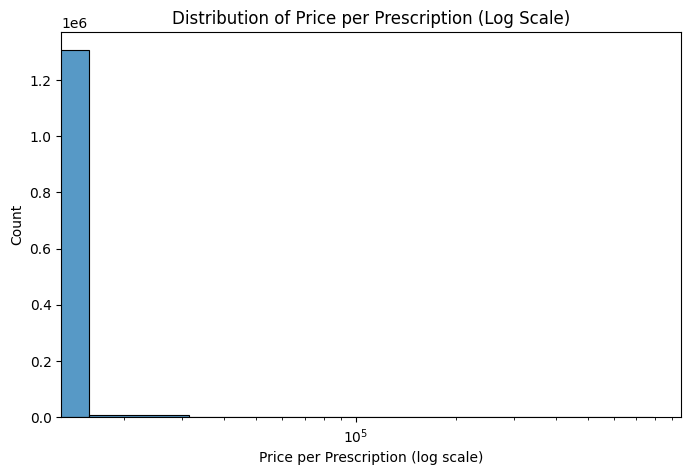

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(df_filtered["price_per_prescription"], bins=50)
plt.xscale("log")
plt.title("Distribution of Price per Prescription (Log Scale)")
plt.xlabel("Price per Prescription (log scale)")
plt.show()



State Level Average Price

In [7]:
state_avg = (
    df.groupby("state")["price_per_prescription"]
    .mean()
    .sort_values(ascending=False)
)

state_avg.head(10)


state
XX    865.297107
CA    761.623844
NY    613.834624
FL    569.194012
TX    562.853343
PR    551.686504
AZ    521.124570
NC    498.700483
PA    492.485101
CT    473.950809
Name: price_per_prescription, dtype: float64

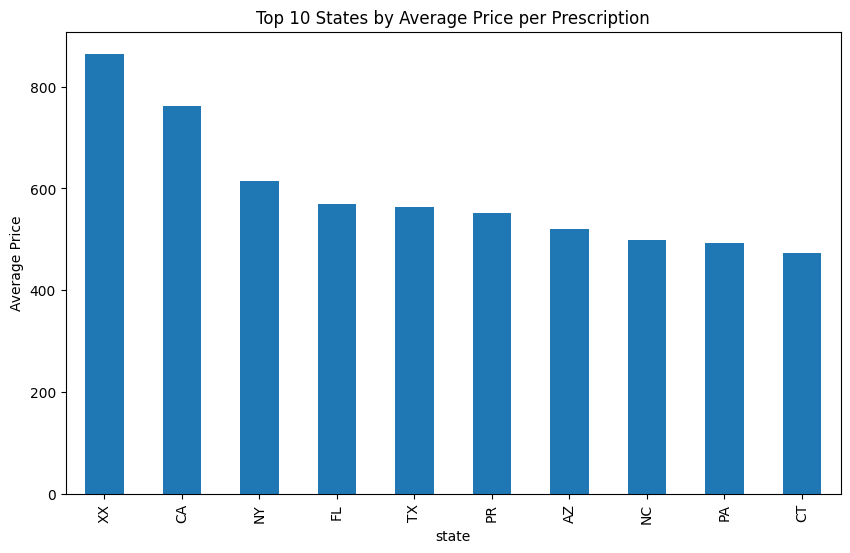

In [8]:
plt.figure(figsize=(10,6))
state_avg.head(10).plot(kind="bar")
plt.title("Top 10 States by Average Price per Prescription")
plt.ylabel("Average Price")
plt.show()


Quarterly Trend

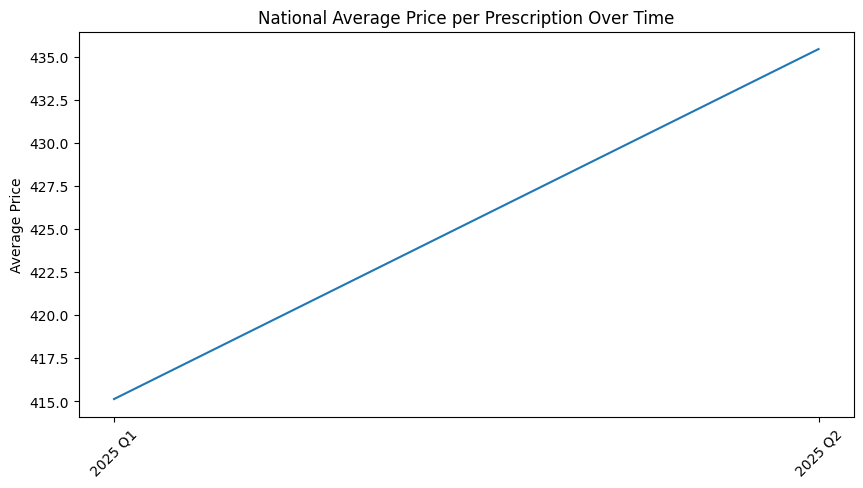

In [9]:
quarter_avg = (
    df.groupby(["year", "quarter"])["price_per_prescription"]
    .mean()
    .reset_index()
)

quarter_avg["time"] = quarter_avg["year"].astype(str) + " Q" + quarter_avg["quarter"].astype(str)

plt.figure(figsize=(10,5))
plt.plot(quarter_avg["time"], quarter_avg["price_per_prescription"])
plt.xticks(rotation=45)
plt.title("National Average Price per Prescription Over Time")
plt.ylabel("Average Price")
plt.show()


In [10]:
# Identifying Outliers

df.sort_values("price_per_prescription", ascending=False).head(10)


,utilization_id,ndc,utilization_type,state,year,quarter,suppression_used,units_reimbursed,number_of_prescriptions,total_amount_reimbursed,medicaid_amount_reimbursed,non_medicaid_amount_reimbursed,price_per_prescription
1756142,1756143,169720501,FFSU,NV,2025,2,False,784.000,14.0,11015342.38,11015342.38,0.00,786810.170000
1387125,1387126,68982026102,FFSU,XX,2025,2,False,27989.000,15.0,8045993.52,8041091.84,4901.68,536399.568000
1783440,1783441,26382850,FFSU,NV,2025,1,False,2115808.000,12.0,4277317.04,4277317.04,0.00,356443.086667
1754190,1754191,26382850,FFSU,NV,2025,2,False,3296037.000,15.0,5065977.93,3116093.60,1949884.33,337731.862000
1408452,1408453,169720801,FFSU,XX,2025,1,False,288.875,18.0,5384363.38,5384363.38,0.00,299131.298889
1408450,1408451,169720501,FFSU,XX,2025,1,False,822.200,42.0,11246458.96,11245945.34,513.62,267772.832381
1137658,1137659,10122050201,MCOU,MN,2025,2,False,330.000,11.0,2939743.17,2939743.17,0.00,267249.379091
1421980,1421981,10122050201,FFSU,XX,2025,1,False,1302.000,42.0,11063494.30,11063494.30,0.00,263416.530952
1341653,1341654,10122050201,FFSU,XX,2025,2,False,984.000,36.0,8662495.34,8662495.34,0.00,240624.870556
160326,160327,10122050201,FFSU,CA,2025,2,False,468.000,18.0,4158005.22,4158005.22,0.00,231000.290000


**Drug Table EDA**

In [13]:
drug_df = pd.read_sql_query("SELECT * FROM drug;", conn)

drug_df.head()


,ndc,labeler_code,product_code,package_size,product_name
0,2143380,2,1433,80,TRULICITY
1,2143480,2,1434,80,TRULICITY
2,2143611,2,1436,11,EMGALITY P
3,2144511,2,1445,11,TALTZ AUTO
4,2144527,2,1445,27,TALTZ AUTO


In [14]:
#Overview

print("Number of unique drugs (NDCs):", drug_df["ndc"].nunique())
print("Number of unique manufacturers (labeler_code):", drug_df["labeler_code"].nunique())
print("Number of unique product names:", drug_df["product_name"].nunique())


Number of unique drugs (NDCs): 46997
Number of unique manufacturers (labeler_code): 824
Number of unique product names: 7070


**Manufacturer Distribution**

In [15]:
manufacturer_counts = (
    drug_df["labeler_code"]
    .value_counts()
    .head(10)
)

manufacturer_counts


labeler_code
63323    1083
904      1050
409       997
60687     852
378       828
16714     761
65862     732
31722     670
93        641
60505     574
Name: count, dtype: int64

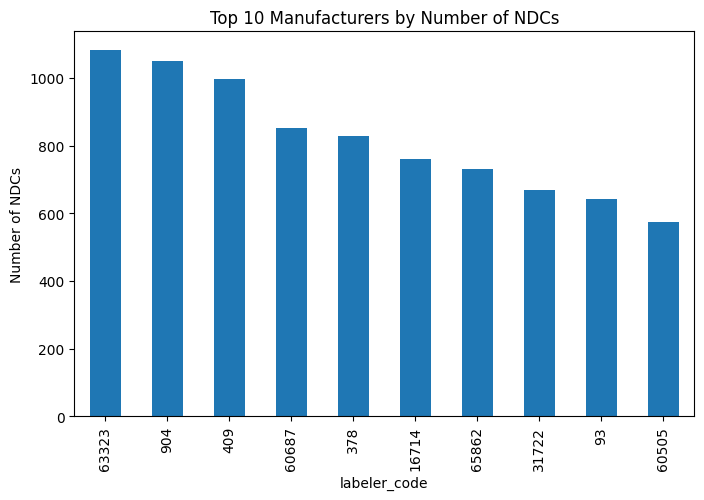

In [16]:
plt.figure(figsize=(8,5))
manufacturer_counts.plot(kind="bar")
plt.title("Top 10 Manufacturers by Number of NDCs")
plt.ylabel("Number of NDCs")
plt.show()


**Product Name Frequency**

In [19]:
product_counts = (
    drug_df["product_name"]
    .value_counts()
    .head(10)
)

product_counts


product_name
POTASSIUM     392
              366
LEVOTHYROX    329
GABAPENTIN    306
METOPROLOL    293
ATORVASTAT    280
AMLODIPINE    273
METFORMIN     271
LEVETIRACE    270
LIDOCAINE     258
Name: count, dtype: int64

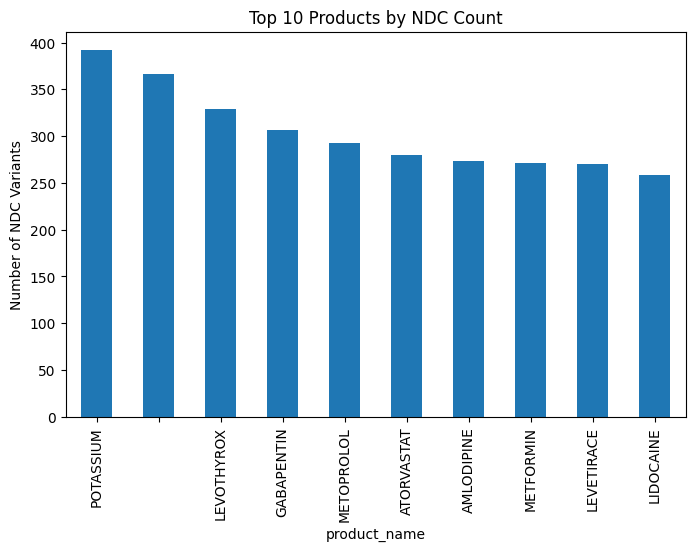

In [20]:
plt.figure(figsize=(8,5))
product_counts.plot(kind="bar")
plt.title("Top 10 Products by NDC Count")
plt.ylabel("Number of NDC Variants")
plt.show()


**Checking Duplicate Drug Names**

In [17]:
duplicate_products = (
    drug_df.groupby("product_name")["ndc"]
    .count()
    .sort_values(ascending=False)
    .head(10)
)

duplicate_products


product_name
POTASSIUM     392
              366
LEVOTHYROX    329
GABAPENTIN    306
METOPROLOL    293
ATORVASTAT    280
AMLODIPINE    273
METFORMIN     271
LEVETIRACE    270
LIDOCAINE     258
Name: ndc, dtype: int64